[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-traditional/testing_lsh.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-traditional/testing_lsh.ipynb)

# Testing LSH

This notebook covers the implementation (with Numpy) and testing of a traditional LSH process. Covering shingling, MinHashing, and a straightforward LSH banding process for identifying candidate pairs.

The first thing we need is data.

In [1]:
import requests
import pandas as pd
import numpy as np
import io

url = "https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt"

text = requests.get(url).text

data = pd.read_csv(io.StringIO(text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


We will take the text from just one column.

In [2]:
sentences = data['sentence_A'].tolist()
sentences[:3]

['A group of kids is playing in a yard and an old man is standing in the background',
 'A group of children is playing in the house and there is no man standing in the background',
 'The young boys are playing outdoors and the man is smiling nearby']

We have our data, now to shingle and one-hot encode it.

In [3]:
sentences[3000]

'The young boys are posing with a green soccer ball in a park'

In [4]:
def build_shingles(sentence: str, k: int):
    shingles = []
    for i in range(len(sentence) - k):
        shingles.append(sentence[i:i+k])
    return set(shingles)

def build_vocab(shingle_sets: list):
    # convert list of shingle sets into single set
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

def one_hot(shingles: set, vocab: dict):
    vec = np.zeros(len(vocab))
    for shingle in shingles:
        idx = vocab[shingle]
        vec[idx] = 1
    return vec

In [5]:
k = 8  # shingle size

# build shingles
shingles = []
for sentence in sentences:
    shingles.append(build_shingles(sentence, k))

# build vocab
vocab = build_vocab(shingles)

# one-hot encode our shingles
shingles_1hot = []
for shingle_set in shingles:
    shingles_1hot.append(one_hot(shingle_set, vocab))
# stack into single numpy array
shingles_1hot = np.stack(shingles_1hot)
shingles_1hot.shape

(4500, 36466)

In [6]:
shingles_1hot[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
sum(shingles_1hot[0])  # confirm we have 1s

73.0

## MinHash

Now we move onto minhashing, first we need to create functions for building a range of minhash vectors, and another to process our sparse vectors through this minhash array - to produce our signatures.

In [8]:
def minhash_arr(vocab: dict, resolution: int):
    length = len(vocab.keys())
    arr = np.zeros((resolution, length))
    for i in range(resolution):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
    return arr.astype(int)

def get_signature(minhash, vector):
    # get index locations of every 1 value in vector
    idx = np.nonzero(vector)[0].tolist()
    # use index locations to pull only +ve positions in minhash
    shingles = minhash[:, idx]
    # find minimum value in each hash vector
    signature = np.min(shingles, axis=1)
    return signature

In [9]:
arr = minhash_arr(vocab, 100)

signatures = []

for vector in shingles_1hot:
    signatures.append(get_signature(arr, vector))

# merge signatures into single array
signatures = np.stack(signatures)
signatures.shape

(4500, 100)

In [10]:
signatures[0]

array([ 196,  215,  760,  245,  245,  154,   47,   40,  824,  278,   80,
       1425,  863, 1108, 1556,  161, 1053,  254,  341,  217,   57,   58,
        564,  228,   49,  904,   99,  758,   34,  326,  191,   94, 1703,
        453,  662,   11,   22,   57,  337, 1099,  543,  484,  198,  316,
        712,   64,  583,  269,  311,  798, 1334, 1780,  107, 1142,   18,
       1118,  224,  479,  234,   10,  400,  861,  161,  347,  432,  560,
        371,  139, 2621,  100,  312,  829,  160,   39,  105,  363,  714,
        362,  103, 1319,  599,  430,  688,  871,  303,  242, 1790,  671,
         17,   90,  355,  295, 1426,  103,  454,   62,  405,  595,   81,
        162])

## LSH

Finally, we move onto the LSH process. We will use a class here:

In [11]:
from itertools import combinations

class LSH:
    buckets = []
    counter = 0
    def __init__(self, b):
        self.b = b
        for i in range(b):
            self.buckets.append({})

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = int(l / self.b)
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)
    
    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            subvec = ','.join(subvec)
            if subvec not in self.buckets[i].keys():
                self.buckets[i][subvec] = []
            self.buckets[i][subvec].append(self.counter)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for bucket_band in self.buckets:
            keys = bucket_band.keys()
            for bucket in keys:
                hits = bucket_band[bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

In [12]:
b = 20

lsh = LSH(b)

for signature in signatures:
    lsh.add_hash(signature)

In [13]:
lsh.buckets

[{'196,215,760,245,245': [0],
  '105,11,742,245,45': [1],
  '203,1035,1178,552,189': [2, 4],
  '1379,191,435,552,159': [3],
  '234,2405,1840,1603,1644': [5],
  '1092,510,1040,4057,745': [6, 7],
  '29,1008,3154,819,930': [8],
  '29,1008,2064,819,930': [9],
  '396,1261,219,1064,365': [10],
  '49,280,200,999,930': [11, 12],
  '311,699,156,567,930': [13],
  '501,109,352,1388,145': [14],
  '491,2616,99,1796,395': [15],
  '501,2616,99,982,395': [16],
  '501,109,352,709,945': [17],
  '491,5407,99,1796,395': [18],
  '960,446,2718,714,1609': [19],
  '871,446,2718,265,2578': [20],
  '17,446,616,1386,198': [21, 22],
  '1302,3270,70,447,855': [23],
  '3300,446,1124,19,1069': [24],
  '947,446,609,19,399': [25],
  '2506,446,1053,19,1069': [26],
  '1322,446,37,45,59': [27, 28, 33, 34],
  '1251,627,270,241,59': [29],
  '1113,522,1295,1345,536': [30, 31],
  '300,303,2215,1345,2630': [32],
  '611,446,909,1265,3354': [35, 39, 41],
  '1600,446,742,3393,810': [36],
  '611,1281,909,2276,2138': [37, 38],
  '

Now we've filled our hash buckets all we need to do is loop through each and where we have multiple entries in a single bucket, mark these as our candidate pairs.

In [14]:
candidate_pairs = lsh.check_candidates()
len(candidate_pairs)

7045

In [15]:
list(candidate_pairs)[:5]

[(3877, 3878), (867, 1131), (827, 1769), (1979, 1981), (2075, 2214)]

We now have all of our candidate pairs!

In [16]:
print(sentences[2075], ":", sentences[2214])


A woman is slicing garlic : A woman is slicing a fish


In [17]:
sentences[2235]

'A woman is slicing an onion'

## Optimizing the Bands

Now let's visualize the actual cosine similarity of our signature vectors against whether we identified the signatures as candidate pairs or not.

(we will also calculate Jaccard but it's less useful here, try both!)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

In [19]:
pairs = pd.DataFrame({
    'x': [],
    'y': [],
    'jaccard': [],
    'cosine': [],
    'candidate': []
})

data_len = shingles_1hot.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 50_000
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = signatures[x]
    vector_y = signatures[y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x], [vector_y])[0][0]
    pairs = pd.concat([pairs, pd.DataFrame([{
            'x': x,
            'y': y,
            'jaccard': jaccard(set(vector_x), set(vector_y)),
            'cosine': cosine,
            'candidate': candidate
        }])], ignore_index=True)

# add a normalized cosine column for better alignment
cos_min = pairs['cosine'].min()
cos_max = pairs['cosine'].max()
pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)

In [20]:
pairs.head()

,x,y,jaccard,cosine,candidate,cosine_norm
0,1719.0,1539.0,0.000000,0.548405,0.0,0.361336
1,702.0,4191.0,0.021164,0.583332,0.0,0.410730
2,2040.0,922.0,0.037234,0.458925,0.0,0.234789
3,3290.0,3382.0,0.021164,0.485088,0.0,0.271790
4,1326.0,1572.0,0.020619,0.464874,0.0,0.243202


<AxesSubplot: xlabel='cosine', ylabel='candidate'>

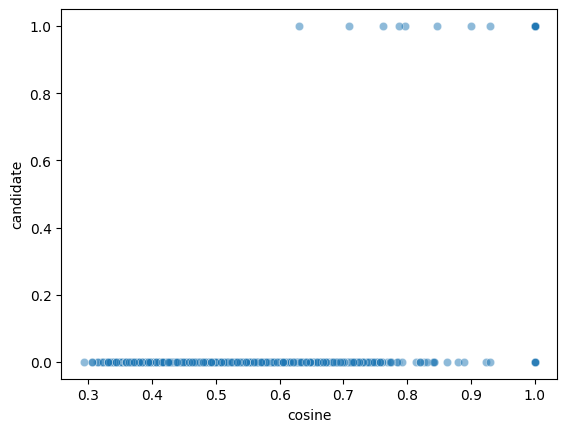

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.5)

Now, this is an *interesting* way to visualize our distribution, but we have reason. We can actually tune our LSH function using `b`, and we have a formalized function that tells us the probability of identifying a pair as candidate pairs given their similarity. We calculate this as so:

In [22]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

Let's visualize that for our current parameters, alongside our scatter plot.

<AxesSubplot: xlabel='cosine', ylabel='candidate'>

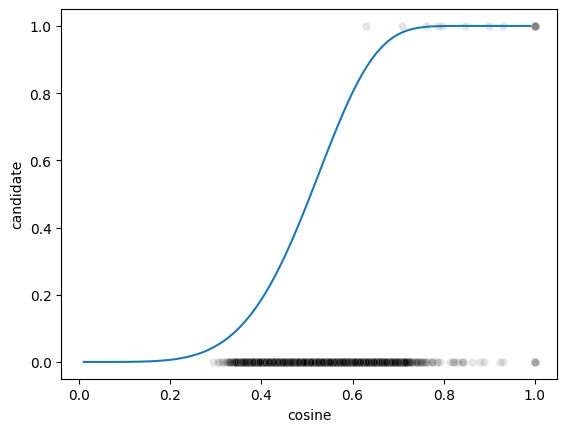

In [23]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.1, color='k')

<AxesSubplot: xlabel='cosine_norm', ylabel='candidate'>

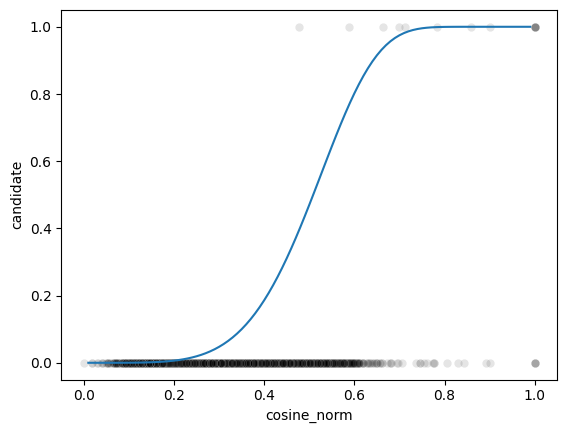

In [24]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidate', alpha=0.1, color='k')

From here we can attempt to modify the similarity threshold `t` - which is the cut-off point on our similarity axes as to where we would like a given cosine similarity to rate as a candidate pair or not.

Let's try a few different band values with our probability formula to see where this balance may be.

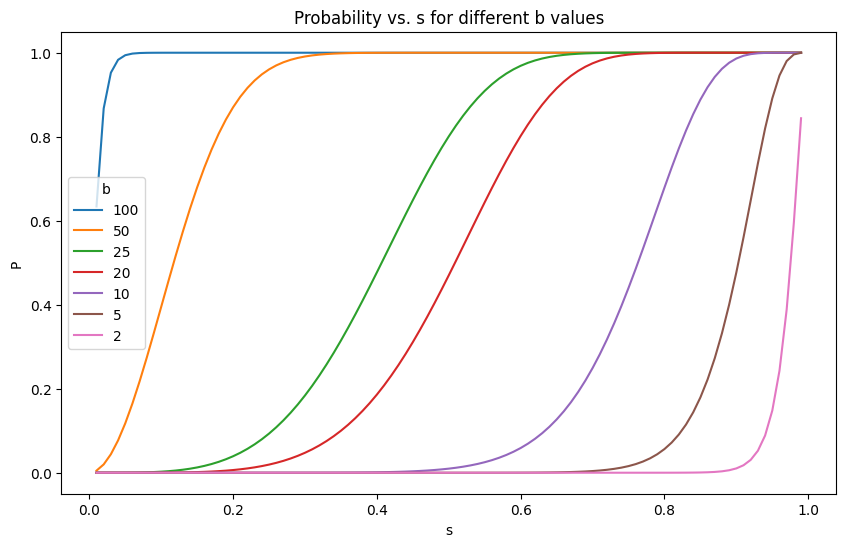

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

all_data = []

for b in [100, 50, 25, 20, 10, 5, 2]:
    r = int(100 / b)
    s_scores = np.arange(0.01, 1, 0.01)
    P_scores = [probability(s, r, b) for s in s_scores]
    
    temp_df = pd.DataFrame({
        'P': P_scores,
        's': s_scores,
        'b': [str(b)] * len(s_scores)
    })
    all_data.append(temp_df)

probs = pd.concat(all_data, ignore_index=True)
    
plt.figure(figsize=(10, 6))
sns.lineplot(data=probs, x='s', y='P', hue='b')
plt.title('Probability vs. s for different b values')
plt.xlabel('s')
plt.ylabel('P')
plt.show()

So a `b` value of `20` have us a threshold value `t` slightly too high (depending on our definition of 'similar'), so maybe we can use `b == 25` to get a better distribution of our candidate pairs.

Let's try:

In [26]:
b = 25

lsh = LSH(b)

for signature in signatures:
    lsh.add_hash(signature)

candidate_pairs = lsh.check_candidates()
len(candidate_pairs)

13546

In [27]:
pairs = pd.DataFrame({
    'x': [],
    'y': [],
    'jaccard': [],
    'cosine': [],
    'candidate': []
})

data_len = shingles_1hot.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 50_000
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = signatures[x]
    vector_y = signatures[y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x], [vector_y])[0][0]
    pairs = pd.concat([pairs, pd.DataFrame([{
            'x': x,
            'y': y,
            'jaccard': jaccard(set(vector_x), set(vector_y)),
            'cosine': cosine,
            'candidate': candidate
        }])], ignore_index=True)

# add a normalized cosine column for better alignment
cos_min = pairs['cosine'].min()
cos_max = pairs['cosine'].max()
pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)

<AxesSubplot: xlabel='cosine', ylabel='candidate'>

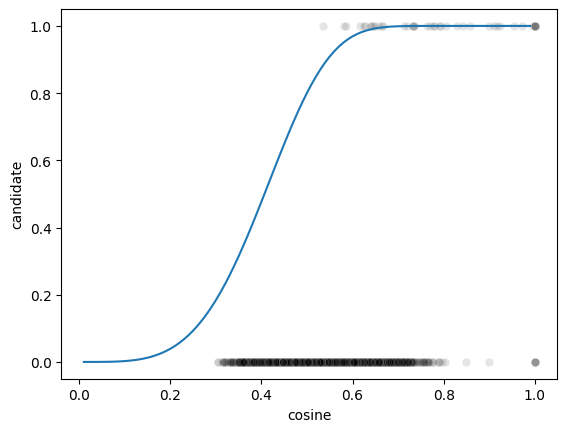

In [28]:
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.1, color='k')

<AxesSubplot: xlabel='cosine_norm', ylabel='candidate'>

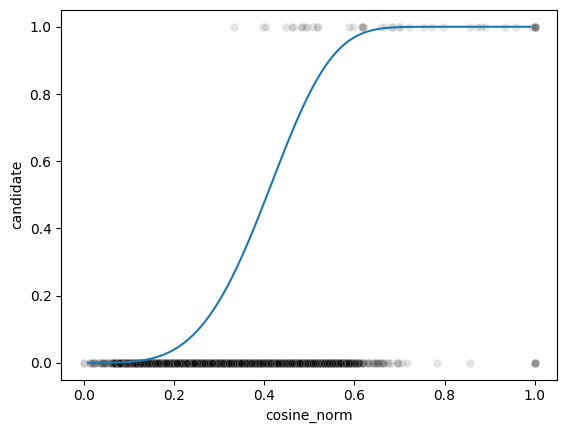

In [29]:
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidate', alpha=0.1, color='k')

Shifting from `b == 20` to `b == 25` has reduced the number of non-candidates around `0.7 - 0.8`, and we can see that the number of candidate pairs in total has increased significantly too, from `7468` to `19436`.

Now, in our own use-cases, the preferred similarity threshold will of-course change.

It's also worth noting that different similarity metrics will produce different charts:

<AxesSubplot: xlabel='jaccard', ylabel='candidate'>

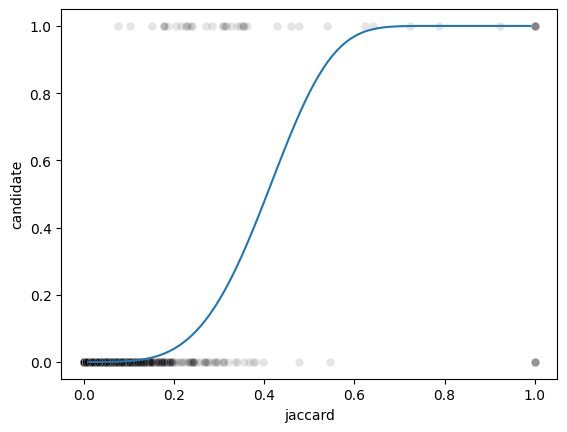

In [30]:
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='jaccard', y='candidate', alpha=0.1, color='k')